#  ARIMA: World Population Forecasting
📌 Dataset: World Population Growth
📈 Objective: Forecast global population trends based on historical data.
🔧 Approach:

Used ARIMA (AutoRegressive Integrated Moving Average) to model and predict population growth.
Performed stationarity tests (ADF test) and differencing to stabilize the time series.
Tuned ARIMA hyperparameters (p, d, q) to optimize forecast accuracy.
Evaluated model performance with residual diagnostics and AIC/BIC selection.


# EDA

In [82]:
# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [83]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maheshmani13/world-population-growth")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\caioe\.cache\kagglehub\datasets\maheshmani13\world-population-growth\versions\1


In [84]:
import os



print("Files:")
print(os.listdir(path))


Files:
['World Population Growth.csv']


In [85]:

csv_path = f"{path}\\World Population Growth.csv"  


df = pd.read_csv(csv_path, index_col='Year', parse_dates=True)  






In [86]:
df.head()

,Population,Yearly Growth %,Number,Density (Pop/km2)
Year,,,,
1951-01-01,"2,543,130,380",1.75%,"43,808,223",17
1952-01-01,"2,590,270,899",1.85%,"47,140,519",17
1953-01-01,"2,640,278,797",1.93%,"50,007,898",18
1954-01-01,"2,691,979,339",1.96%,"51,700,542",18
1955-01-01,"2,746,072,141",2.01%,"54,092,802",18


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 1951-01-01 to 2023-01-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Population         73 non-null     object
 1   Yearly Growth %    73 non-null     object
 2   Number             73 non-null     object
 3   Density (Pop/km2)  73 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.9+ KB


In [88]:
df['Population'] = df['Population'].str.replace(",", "").astype('Int64')

In [89]:
df = df[['Population']]


In [90]:
df.head()

,Population
Year,
1951-01-01,2543130380
1952-01-01,2590270899
1953-01-01,2640278797
1954-01-01,2691979339
1955-01-01,2746072141


# Time Series Visualization

In [91]:
import matplotlib.pyplot as plt

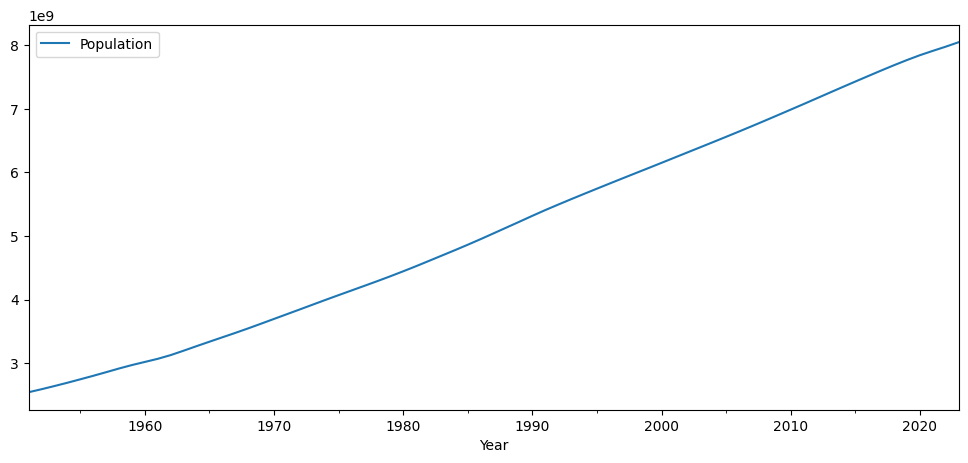

In [92]:
df.plot(figsize=(12,5))
plt.show();

In [93]:
result = seasonal_decompose(df, model='additive')

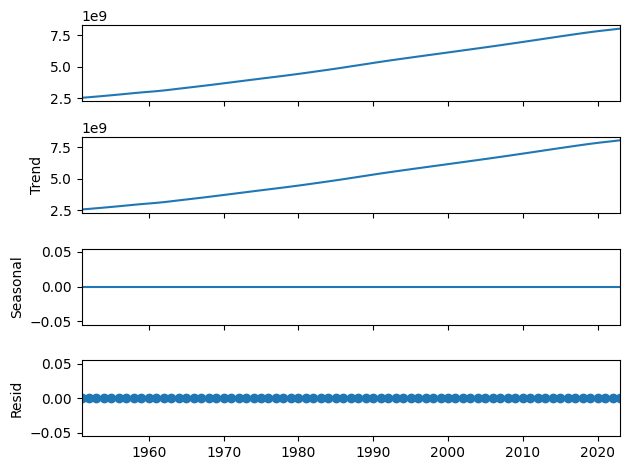

In [94]:
result.plot()
plt.show();

# Stancionarity

In [95]:
import pandas as pd

def auto_differencing_df(series, n):
 
    
    differenced_series = pd.DataFrame()

    
    differenced_series['Original'] = series

   
    for i in range(1, n + 1):
        differenced_series[f"Differenced_{i}"] = series.diff(i)

    
    differenced_series = differenced_series.dropna().reset_index(drop=True)

    return differenced_series




In [96]:
#Number of diffs
n = 3


differenced_df = auto_differencing_df(df["Population"], n)

differenced_df.head()

,Original,Differenced_1,Differenced_2,Differenced_3
0,2691979339,51700542,101708440,148848959
1,2746072141,54092802,105793344,155801242
2,2801002631,54930490,109023292,160723834
3,2857866857,56864226,111794716,165887518
4,2916108097,58241240,115105466,170035956


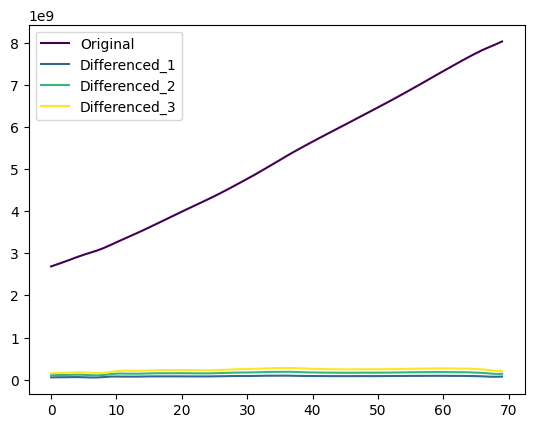

In [97]:
differenced_df.plot(colormap='viridis')
plt.show();

In [98]:
from statsmodels.tsa.stattools import adfuller

adf

In [99]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test_summary(series, max_diff=3):
    """
    Realiza o teste ADF em uma série temporal para diferentes ordens de diferenciação
    e retorna os resultados em formato tabular.

    Parâmetros:
    - series: pd.Series, a série temporal a ser analisada.
    - max_diff: int, o número máximo de diferenciações.

    Retorna:
    - pd.DataFrame com o resumo dos resultados do teste ADF.
    """
    results = []

    for d in range(0, max_diff + 1):
        # Diferenciação da série
        if d == 0:
            series_diff = series  # Série original
            diff_label = "Original"
        else:
            series_diff = series.diff(d).dropna()  # Aplica diferenciação e remove NaN
            diff_label = f"Differentiation {d}"
        
        # Executar o teste ADF
        adf_result = adfuller(series_diff, autolag="AIC")
        
        # Coletar resultados relevantes
        results.append({
            "Differentiation": diff_label,
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Lags Used": adf_result[2],
            "Number of Observations": adf_result[3],
            "Critical Value (1%)": adf_result[4]["1%"],
            "Critical Value (5%)": adf_result[4]["5%"],
            "Critical Value (10%)": adf_result[4]["10%"],
            "Stationary?": "Yes" if adf_result[1] < 0.05 else "No"
        })

    # Converter para DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [100]:
adf_results = adf_test_summary(df["Population"], max_diff=5)


adf_results

,Differentiation,ADF Statistic,p-value,Lags Used,Number of Observations,Critical Value (1%),Critical Value (5%),Critical Value (10%),Stationary?
0,Original,-0.961981,0.766877,12,60,-3.544369,-2.911073,-2.593190,No
1,Differentiation 1,-1.994800,0.288858,10,61,-3.542413,-2.910236,-2.592745,No
2,Differentiation 2,-2.153382,0.223598,10,60,-3.544369,-2.911073,-2.593190,No
3,Differentiation 3,-2.911420,0.044036,10,59,-3.546395,-2.911939,-2.593652,Yes
4,Differentiation 4,-2.480116,0.120388,10,58,-3.548494,-2.912837,-2.594129,No
5,Differentiation 5,-2.463779,0.124538,10,57,-3.550670,-2.913766,-2.594624,No


# Pattern Identification

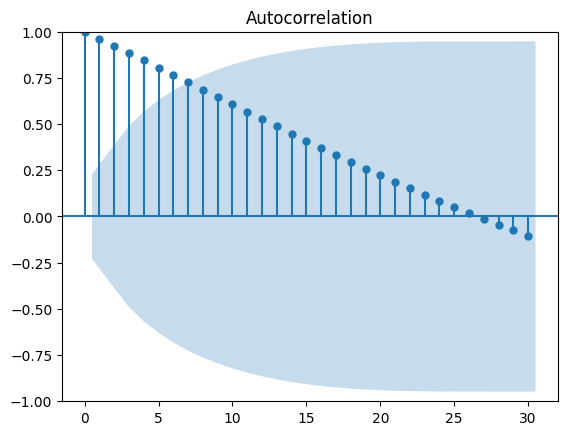

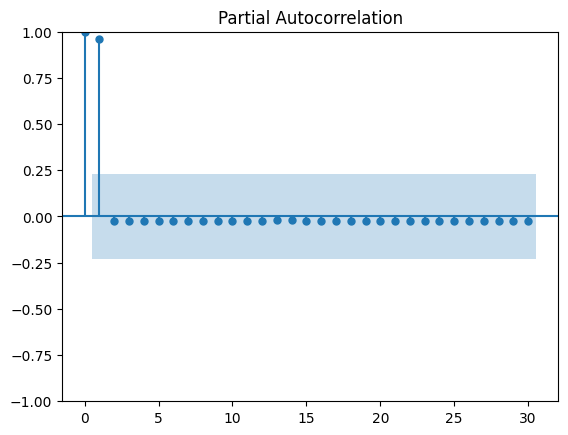

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Gerar os gráficos ACF e PACF para a série temporal
plot_acf(df['Population'], lags=30)  # Ajuste o número de lags conforme necessário
plot_pacf(df['Population'], lags=30)

plt.show();


In [102]:
import pandas as pd
import itertools
from statsmodels.tsa.arima.model import ARIMA


series = df['Population']


p_values = list(range(2))
d_values = list(range(2,4))
q_values = list(range(6))


parameters = list(itertools.product(p_values, d_values, q_values))


results = []


for (p, d, q) in parameters:
    try:
       
        model = ARIMA(series, order=(p, d, q))
        model_fit = model.fit()
        
        
        results.append({
            "p": p,
            "d": d,
            "q": q,
            "AIC": model_fit.aic
        })
    except Exception as e:
        
        print(f"Error (p={p}, d={d}, q={q}): {e}")


results_df = pd.DataFrame(results)


results_df = results_df.sort_values(by="AIC").reset_index(drop=True)


results_df.head(5)



,p,d,q,AIC
0,1,3,1,2246.814341
1,0,3,0,2253.567359
2,1,3,0,2255.557790
3,0,3,2,2266.196029
4,0,3,1,2273.785359


In [103]:
import pmdarima as pm

model = pm.auto_arima(df['Population'], seasonal=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1150.401
Date:                Wed, 05 Feb 2025   AIC                           2302.802
Time:                        15:15:30   BIC                           2305.065
Sample:                    01-01-1951   HQIC                          2303.702
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.744e+12   5.93e+11     11.380      0.000    5.58e+12    7.91e+12
===================================================================================
Ljung-Box (L1) (Q):                  25.15   Jarque-Bera (JB):                71.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.71
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Data Splitting  
# Model Selection

In [104]:
limit = int((len(df)*0.80))
print(limit)

58


In [105]:
train = df.iloc[0:limit]
test = df.iloc[limit:len(df)]

In [106]:
model1 = ARIMA(train['Population'], order=(1,3,1))
model1 = model1.fit()

In [107]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Population   No. Observations:                   58
Model:                 ARIMA(1, 3, 1)   Log Likelihood                -878.774
Date:                Wed, 05 Feb 2025   AIC                           1763.547
Time:                        15:15:31   BIC                           1769.569
Sample:                    01-01-1951   HQIC                          1765.876
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5640      0.077      7.351      0.000       0.414       0.714
ma.L1         -0.9283      0.011    -86.572      0.000      -0.949      -0.907
sigma2      4.968e+12    1.1e-15   4.52e+27      0.000    4.97e+12    4.97e+12
===================================================================================
Ljung-Box (L1) (Q):                   7.25   Jarque-Bera (JB):                85.65
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+43. Standard errors may be unstable.
"""

In [108]:
model2 = SARIMAX(train['Population'], order=(0, 2, 0))
model2 = model2.fit()

# Model

Arima

In [109]:
forecast_arima = model1.forecast(steps=len(test))



Sarima

In [110]:
forecast_sarima = model2.forecast(steps=len(test))

Graphic

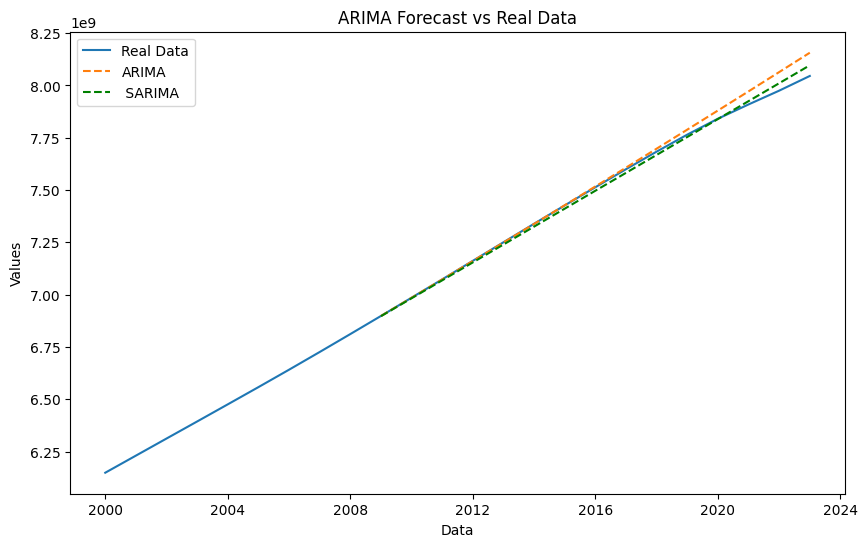

In [111]:
# Plotar as séries temporais
plt.figure(figsize=(10, 6))
plt.plot(df['Population'].iloc[-24:], label='Real Data')  # Série original
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--')  # Previsões
plt.title('ARIMA Forecast vs Real Data')
plt.plot(test.index, forecast_sarima, label=' SARIMA ', color='green', linestyle='--')  # Previsões model2
plt.xlabel('Data')
plt.ylabel('Values')
plt.legend()
plt.show();

# Model Accuracy

In [112]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


Metrics for ARIMA

In [113]:

mae = mean_absolute_error(test['Population'], forecast_arima)
print(f'MAE Arima: {mae}')


rmse = np.sqrt(mean_squared_error(test['Population'], forecast_arima))
print(f'RMSE Arima: {rmse}')

mape = mean_absolute_percentage_error(test['Weekly_Sales'], forecast_arima) * 100
print(f'MAPE Model : {mape:.2f}%')

MAE Arima: 23738547.449883714
RMSE Arima: 42053741.522779696


KeyError: 'Weekly_Sales'

Metrics for SARIMA

In [281]:
mae = mean_absolute_error(test['Population'], forecast_sarima)
print(f'MAE Sarima: {mae}')

rmse = np.sqrt(mean_squared_error(test['Population'], forecast_sarima))
print(f'RMSE Sarima: {rmse}')

mape = mean_absolute_percentage_error(test['Weekly_Sales'], forecast_arima) * 100
print(f'MAPE Model : {mape:.2f}%')

MAE Sarima: 23738547.449883714
RMSE Sarima: 42053741.522779696


# Forecast

Arima (1,3,1) is the best model 

In [313]:
model1 = ARIMA(df['Population'], order=(1,3,1))
model1 = model1.fit()
forecast = model1.forecast(steps=10)

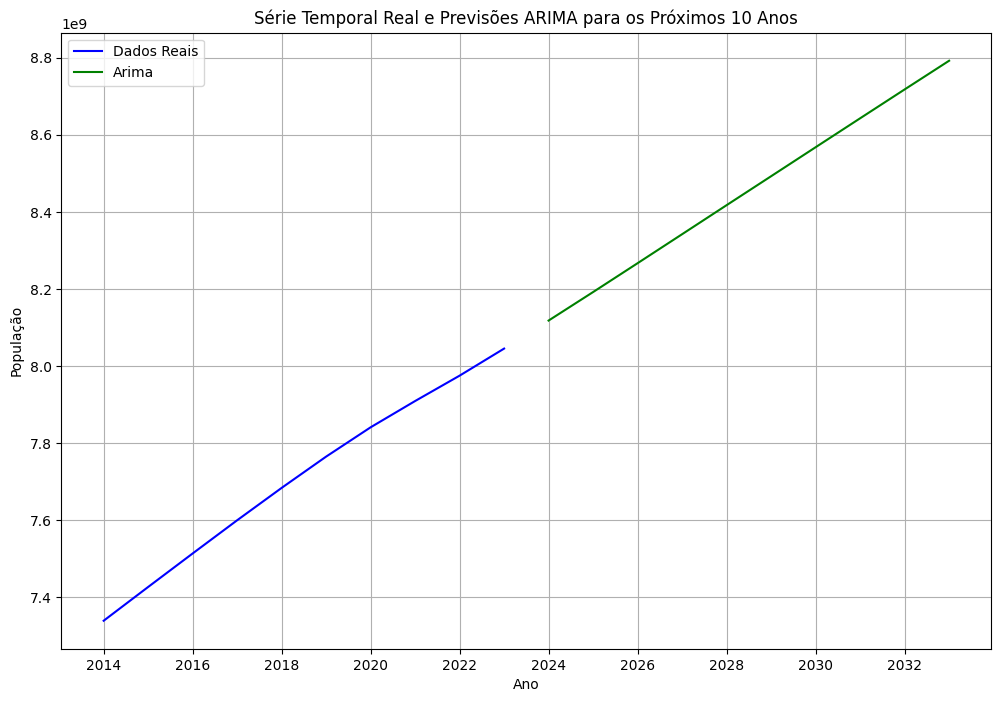

In [321]:
# Plotando os dados reais
plt.figure(figsize=(12, 8))
plt.plot(df.index[-10:], df['Population'].iloc[-10:], label='Real Data', color='blue')
plt.plot(forecast.index, forecast, label='Arima Prediction for the next 10 years', color='green')



# Título e rótulos
plt.title('World Population')
plt.xlabel('Year')
plt.ylabel('Population')

# Legenda
plt.legend()

# Grid para o gráfico
plt.grid(True)

# Mostrar o gráfico
plt.show();